본 과제는 Kaggle의 Diamonds 데이터셋을 활용하여 데이터 전처리부터 탐색적 데이터 분석, 통계적 추
론, 회귀분석까지 데이터 분석의 전체 흐름을 경험하는 것을 목표로 하는 평가 과제 입니다.

“다이아몬드 가격은 왜 이렇게 결정되는 걸까?”


In [121]:
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
import pandas as pd
from math import sqrt
#선형회귀를 위한  참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

#결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import t, ttest_ind, zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

#VIF 값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [122]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

In [ ]:
origin = load_data('diamonds')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")

print(origin.info())

origin.head()

In [ ]:
origin.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    53940 non-null  int64  
 1   carat    53940 non-null  float64
 2   cut      53940 non-null  object 
 3   color    53940 non-null  object 
 4   clarity  53940 non-null  object 
 5   x        53940 non-null  float64
 6   y        53940 non-null  float64
 7   z        53940 non-null  float64
 8   depth    53940 non-null  float64
 9   table    53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [ ]:
origin.describe(include='all')

,price,carat,cut,color,clarity,x,y,z,depth,table
count,53940.000000,53940.000000,53940,53940,53940,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
unique,NaN,NaN,5,7,8,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ideal,G,SI1,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,21551,11292,13065,NaN,NaN,NaN,NaN,NaN
mean,3932.799722,0.797940,NaN,NaN,NaN,5.731157,5.734526,3.538734,61.749405,57.457184
std,3989.439738,0.474011,NaN,NaN,NaN,1.121761,1.142135,0.705699,1.432621,2.234491
min,326.000000,0.200000,NaN,NaN,NaN,0.000000,0.000000,0.000000,43.000000,43.000000
25%,950.000000,0.400000,NaN,NaN,NaN,4.710000,4.720000,2.910000,61.000000,56.000000
50%,2401.000000,0.700000,NaN,NaN,NaN,5.700000,5.710000,3.530000,61.800000,57.000000
75%,5324.250000,1.040000,NaN,NaN,NaN,6.540000,6.540000,4.040000,62.500000,59.000000


### 미션1."이 데이터는 얼마나 믿을 수 있을까?" 

In [ ]:
origin['cut'] = origin['cut'].astype('category')
origin['color'] = origin['color'].astype('category')
origin['clarity'] = origin['clarity'].astype('category')


In [ ]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   price    53940 non-null  int64   
 1   carat    53940 non-null  float64 
 2   cut      53940 non-null  category
 3   color    53940 non-null  category
 4   clarity  53940 non-null  category
 5   x        53940 non-null  float64 
 6   y        53940 non-null  float64 
 7   z        53940 non-null  float64 
 8   depth    53940 non-null  float64 
 9   table    53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


In [ ]:
origin_idx = origin.set_index('price')
origin_idx

,carat,cut,color,clarity,x,y,z,depth,table
price,,,,,,,,,
326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0
...,...,...,...,...,...,...,...,...,...
2757,0.72,Ideal,D,SI1,5.75,5.76,3.50,60.8,57.0
2757,0.72,Good,D,SI1,5.69,5.75,3.61,63.1,55.0
2757,0.70,Very Good,D,SI1,5.66,5.68,3.56,62.8,60.0


In [ ]:

num_cols = origin.select_dtypes(include='number').columns

outlier_summary = {}

for col in num_cols:
    Q1 = origin[col].quantile(0.25)
    Q3 = origin[col].quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_cnt = ((origin[col] < Q1 - 1.5*IQR) | 
                   (origin[col] > Q3 + 1.5*IQR)).sum()


                   
    
    outlier_summary[col] = outlier_cnt

pd.Series(outlier_summary).sort_values(ascending=False)


price    3540
depth    2545
carat    1889
table     605
z          49
x          32
y          29
dtype: int64

In [ ]:
origin[(origin['x'] == 0) | (origin['y'] == 0) | (origin['z'] == 0)]


,price,carat,cut,color,clarity,x,y,z,depth,table
2207,3142,1.00,Premium,G,SI2,6.55,6.48,0.0,59.1,59.0
2314,3167,1.01,Premium,H,I1,6.66,6.60,0.0,58.1,59.0
4791,3696,1.10,Premium,G,SI2,6.50,6.47,0.0,63.0,59.0
5471,3837,1.01,Premium,F,SI2,6.50,6.47,0.0,59.2,58.0
10167,4731,1.50,Good,G,I1,7.15,7.04,0.0,64.0,61.0
11182,4954,1.07,Ideal,F,SI2,0.00,6.62,0.0,61.6,56.0
11963,5139,1.00,Very Good,H,VS2,0.00,0.00,0.0,63.3,53.0
13601,5564,1.15,Ideal,G,VS2,6.88,6.83,0.0,59.2,56.0
15951,6381,1.14,Fair,G,VS1,0.00,0.00,0.0,57.5,67.0
24394,12631,2.18,Premium,H,SI2,8.49,8.45,0.0,59.4,61.0


In [ ]:
df = origin[(origin[['x','y','z']] != 0).all(axis=1)]



In [ ]:
Q1 = df[['x', 'y', 'z']].quantile(0.25)
Q3 = df[['x', 'y', 'z']].quantile(0.75)
IQR = Q3 - Q1

outliers = df[
    (df[['x', 'y', 'z']] < (Q1 - 1.5 * IQR)) |
    (df[['x', 'y', 'z']] > (Q3 + 1.5 * IQR))].any(axis=1)

df[outliers]


,price,carat,cut,color,clarity,x,y,z,depth,table
14635,5909,1.07,Ideal,F,SI1,6.62,6.67,1.07,60.6,57.0
16283,6512,3.00,Very Good,H,I1,9.23,9.10,5.77,63.1,55.0
17196,6870,2.72,Fair,J,I1,8.46,8.43,5.76,68.2,56.0
19346,8044,3.00,Fair,H,I1,8.93,8.84,5.97,67.1,57.0
21758,9823,3.11,Fair,J,I1,9.15,9.02,5.98,65.9,57.0
22540,10577,3.02,Fair,I,I1,9.11,9.02,5.91,65.2,56.0
22741,10761,3.01,Fair,H,I1,9.54,9.38,5.31,56.1,62.0
22831,10863,3.00,Good,I,I1,9.38,9.31,5.33,57.0,64.0
23539,11548,3.00,Good,E,I1,9.08,8.96,5.79,64.2,65.0
23644,11668,3.65,Fair,H,I1,9.53,9.48,6.38,67.1,53.0


In [ ]:
df[['x', 'y', 'z', 'price', 'carat', 'depth','table']].describe()


,x,y,z,price,carat,depth,table
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,5.731627,5.734887,3.540046,3930.993231,0.797698,61.749514,57.456834
std,1.119423,1.140126,0.702530,3987.280446,0.473795,1.432331,2.234064
min,3.730000,3.680000,1.070000,326.000000,0.200000,43.000000,43.000000
25%,4.710000,4.720000,2.910000,949.000000,0.400000,61.000000,56.000000
50%,5.700000,5.710000,3.530000,2401.000000,0.700000,61.800000,57.000000
75%,6.540000,6.540000,4.040000,5323.250000,1.040000,62.500000,59.000000
max,10.740000,58.900000,31.800000,18823.000000,5.010000,79.000000,95.000000


In [ ]:
df[['x', 'y', 'z']].skew()


x    0.398348
y    2.462211
z    1.585490
dtype: float64

In [ ]:
outlier_ratio = outliers.mean() * 100
outlier_ratio


np.float64(0.07603857566765578)

In [ ]:
df['cut'].value_counts(normalize=True)


cut
Ideal        0.399629
Premium      0.255564
Very Good    0.224054
Good         0.090912
Fair         0.029841
Name: proportion, dtype: float64

In [ ]:
df['color'].value_counts(normalize=True)

color
G    0.209273
E    0.181695
F    0.176892
H    0.153895
D    0.125631
I    0.100538
J    0.052077
Name: proportion, dtype: float64

In [ ]:
df['clarity'].value_counts(normalize=True)

clarity
SI1     0.242266
VS2     0.227263
SI2     0.170345
VS1     0.151521
VVS2    0.093954
VVS1    0.067767
IF      0.033197
I1      0.013687
Name: proportion, dtype: float64

In [ ]:
df[outliers].head(10)


,price,carat,cut,color,clarity,x,y,z,depth,table
14635,5909,1.07,Ideal,F,SI1,6.62,6.67,1.07,60.6,57.0
16283,6512,3.00,Very Good,H,I1,9.23,9.10,5.77,63.1,55.0
17196,6870,2.72,Fair,J,I1,8.46,8.43,5.76,68.2,56.0
19346,8044,3.00,Fair,H,I1,8.93,8.84,5.97,67.1,57.0
21758,9823,3.11,Fair,J,I1,9.15,9.02,5.98,65.9,57.0
22540,10577,3.02,Fair,I,I1,9.11,9.02,5.91,65.2,56.0
22741,10761,3.01,Fair,H,I1,9.54,9.38,5.31,56.1,62.0
22831,10863,3.00,Good,I,I1,9.38,9.31,5.33,57.0,64.0
23539,11548,3.00,Good,E,I1,9.08,8.96,5.79,64.2,65.0
23644,11668,3.65,Fair,H,I1,9.53,9.48,6.38,67.1,53.0


In [ ]:
df[['x','y','z']].mean()
df.loc[~outliers, ['x','y','z']].mean()


x    5.729071
y    5.730952
z    3.537829
dtype: float64

In [ ]:
df[['cut', 'color', 'clarity']].nunique()


cut        5
color      7
clarity    8
dtype: int64

In [ ]:
df['cut'].unique()

['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
Categories (5, object): ['Fair', 'Good', 'Ideal', 'Premium', 'Very Good']

In [ ]:
df['color'].unique()

['E', 'I', 'J', 'H', 'F', 'G', 'D']
Categories (7, object): ['D', 'E', 'F', 'G', 'H', 'I', 'J']

In [ ]:
df['clarity'].unique()

['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']
Categories (8, object): ['I1', 'IF', 'SI1', 'SI2', 'VS1', 'VS2', 'VVS1', 'VVS2']

In [ ]:
(df['carat'] < 0).sum()
(df['price'] < 0).sum()



np.int64(0)

In [ ]:
cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]

df["cut"] = pd.Categorical(
    df["cut"],
    categories=cut_order,
    ordered=True
)


C:\Users\itwill\AppData\Local\Temp\ipykernel_16072\1275304513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cut"] = pd.Categorical(


In [ ]:
color_order = ["J", "I", "H", "G", "F", "E", "D"]

df["color"] = pd.Categorical(
    df["color"],
    categories=color_order,
    ordered=True
)


C:\Users\itwill\AppData\Local\Temp\ipykernel_16072\3611160363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["color"] = pd.Categorical(


In [ ]:
clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

df["clarity"] = pd.Categorical(
    df["clarity"],
    categories=clarity_order,
    ordered=True
)


C:\Users\itwill\AppData\Local\Temp\ipykernel_16072\2345648857.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["clarity"] = pd.Categorical(


In [ ]:
df["cut"].cat.categories
df["color"].cat.categories
df["clarity"].cat.categories


Index(['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'], dtype='object')

cut: Fair  →  Good  →  Very Good  →  Premium  →  Ideal
color: J  →  I  →  H  →  G  →  F  →  E  →  D
clarity:I1  →  SI2  →  SI1  →  VS2  →  VS1  →  VVS2  →  VVS1  →  IF
등급 순을 알아봄 왼쪽부터 낮은 등급

결측치는 존재하지 않아 별도의 처리를 하지 않았다.
다만 x, y, z(길이, 너비, 두께) 컬럼에서 0인 값이 존재하였는데, 이는 실제 다이아몬드의 물리적 특성상 발생할 수 없는 값으로 판단하여 데이터 오류로 간주하고 제거하였다.
price, carat, depth, table 컬럼에 대해서는 사전 정의된 정상 범위를 벗어나는 값이 존재하지 않아 이상치로 판단되는 데이터는 제거하지 않았다. 이는 고가 또는 고중량 다이아몬드가 실제로 존재할 수 있으며, 해당 데이터를 제거할 경우 정보 손실이 발생할 수 있기 때문이다.
또한 cut, color, clarity와 같은 범주형 품질 변수에 대해 범주 개수와 분포를 확인한 결과, 특정 범주에 데이터가 과도하게 집중되지 않고 비교적 고르게 분포되어 있어 모델 학습 시 편향 문제는 크지 않을 것으로 판단하였다.


결측치는 존재하지 않았다.
x, y, z 컬럼에서 0인 값은 실제 다이아몬드 특성상 불가능한 데이터로 판단하여 제거하였다.
price, carat, depth, table 컬럼은 정상 범위를 벗어나는 값이 없어 이상치를 별도로 제거하지 않았다.
cut, color, clarity의 범주 개수와 분포를 확인한 결과, 특정 범주에 과도한 편향은 없었다.

# 미션2."가격 데이터는 어떤 모습일까?"

In [ ]:
df["price"].head()

0    326
1    326
2    327
3    334
4    335
Name: price, dtype: int64

In [ ]:
df["price"].min()

np.int64(326)

In [ ]:

df["price"].max()


np.int64(18823)

<Axes: >

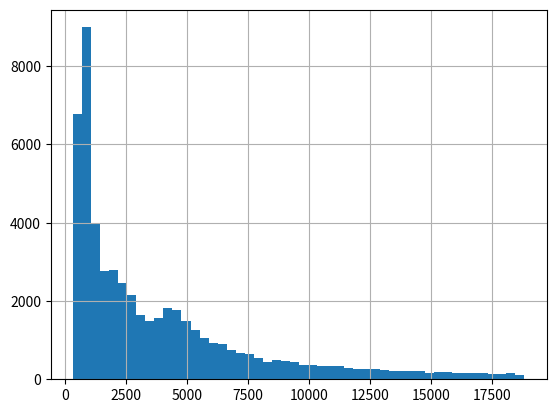

In [ ]:
df["price"].hist(bins=50)


price 변수의 히스토그램을 확인한 결과,가격범위가 매우 넓으며,
관측치가 낮은 가격 구간에 집중되어 있으며
오른쪽으로 긴 꼬리를 가진 분포를 보인다.
이는 소수의 고가 다이아몬드가 존재함을 의미하며,
이러한 상태에서 단순 선형회귀를 적용할 경우
극단값의 영향이 클 수 있다.

<Axes: >

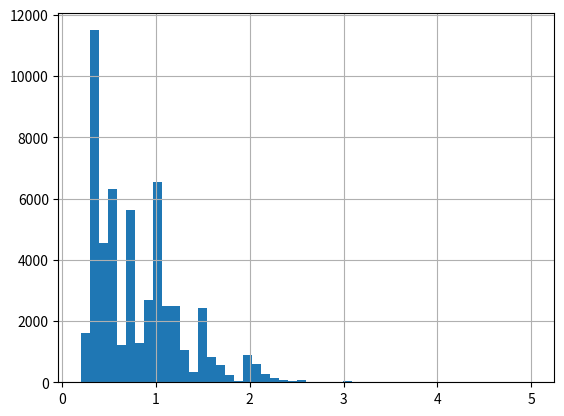

In [ ]:
df["carat"].hist(bins=50)


In [ ]:
df["carat"].min(), df["carat"].max()

(np.float64(0.2), np.float64(5.01))

carat 변수의 분포를 확인한 결과,
낮은 캐럿 구간에 관측치가 집중되어 있으며
오른쪽으로 꼬리가 긴 분포를 보인다.

두 변수 모두 소수의 큰 값이 존재하는 비대칭 분포라는
공통점을 가진다.
다만 price는 carat보다 분포의 왜곡이 더 크며,
carat은 특정 값 구간에 관측치가 집중되는 특징을 보인다.

price와 carat 변수는 모두 오른쪽으로 치우친 비대칭 분포를 보이며,
소수의 큰 값이 회귀 결과에 과도한 영향을 미칠 수 있다.
따라서 회귀분석에 앞서 로그 변환 등의 변수 변환이 필요하다.

# 미션 3. “로그 변환은 왜 등장할까?”

In [ ]:
df["log_price"] = np.log(df["price"])
df["log_carat"] = np.log(df["carat"])

C:\Users\itwill\AppData\Local\Temp\ipykernel_16072\1287984676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["log_price"] = np.log(df["price"])
C:\Users\itwill\AppData\Local\Temp\ipykernel_16072\1287984676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["log_carat"] = np.log(df["carat"])


<Axes: >

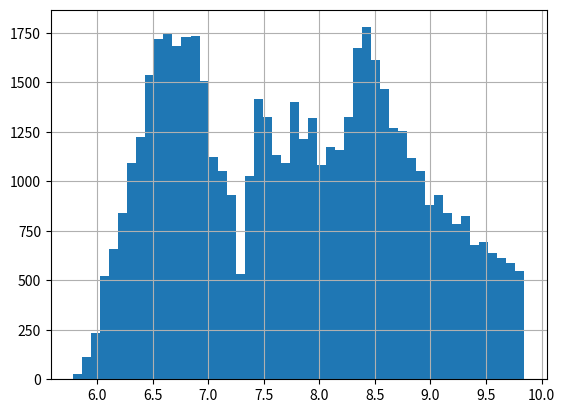

In [ ]:
df["log_price"].hist(bins=50)


<Axes: >

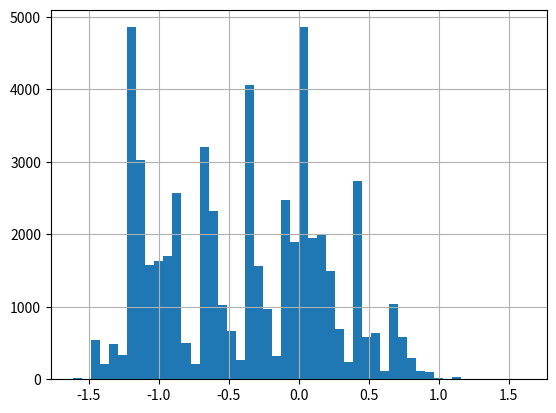

In [ ]:
df["log_carat"].hist(bins=50)


이유:로그 변환은 오른쪽으로 치우친 분포를 완화하고
소수의 큰 값이 회귀분석 결과에 미치는 영향을 줄이기 위해 사용하였다.
이를 통해 회귀 가정(선형성, 등분산성)을 보다 잘 만족시키고자 하였다.

비교:로그 변환 전 price와 carat 변수는 낮은 값 구간에 관측치가 집중되어 있고,
오른쪽으로 긴 꼬리를 가진 비대칭 분포를 보였다.
로그 변환 후에는 분포의 왜곡이 완화되었으며,
극단값의 영향이 줄어들고 보다 완만한 분포 형태를 나타냈다.

#  미션 4. “품질 등급은 가격을 얼마나 설명해 줄까?”

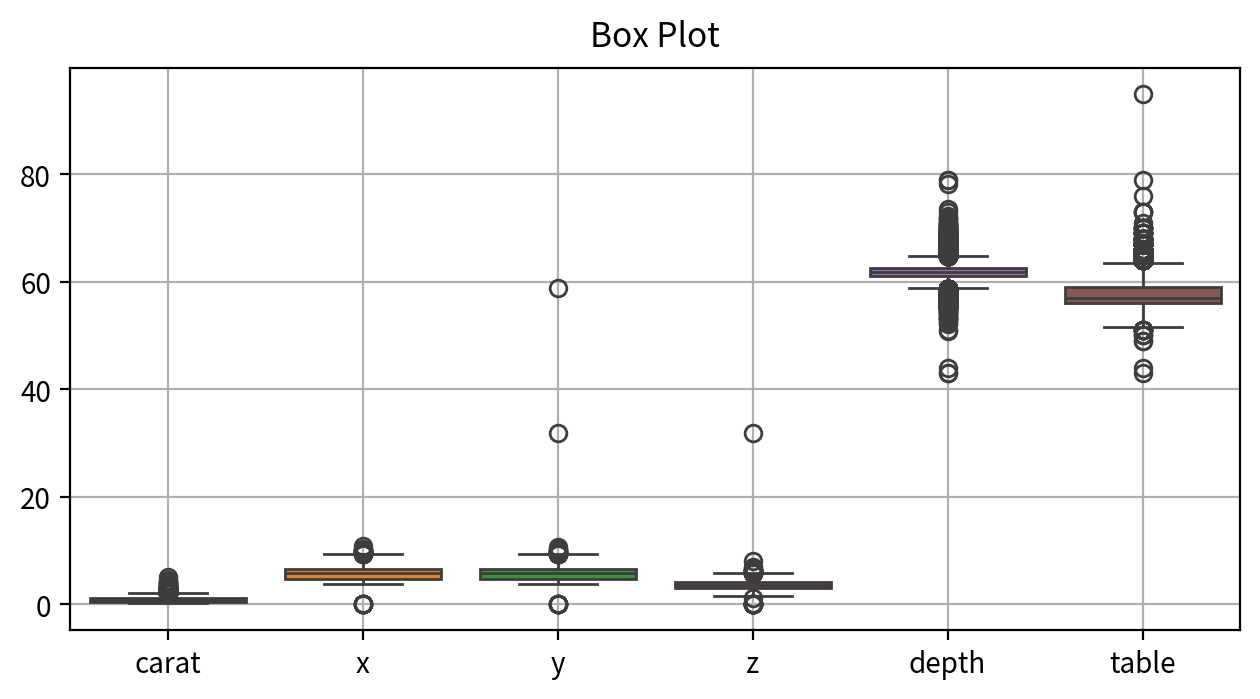

In [ ]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.boxplot(data=origin_idx)

ax.set_title("Box Plot", fontsize=12, pad=8)
ax.grid(True)


plt.tight_layout()
plt.show()
plt.close()

스탠다드스케일링할지말지 고민중

C:\Users\itwill\AppData\Local\Temp\ipykernel_16072\1618526408.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=df,x='cut', y='price',palette='Blues')


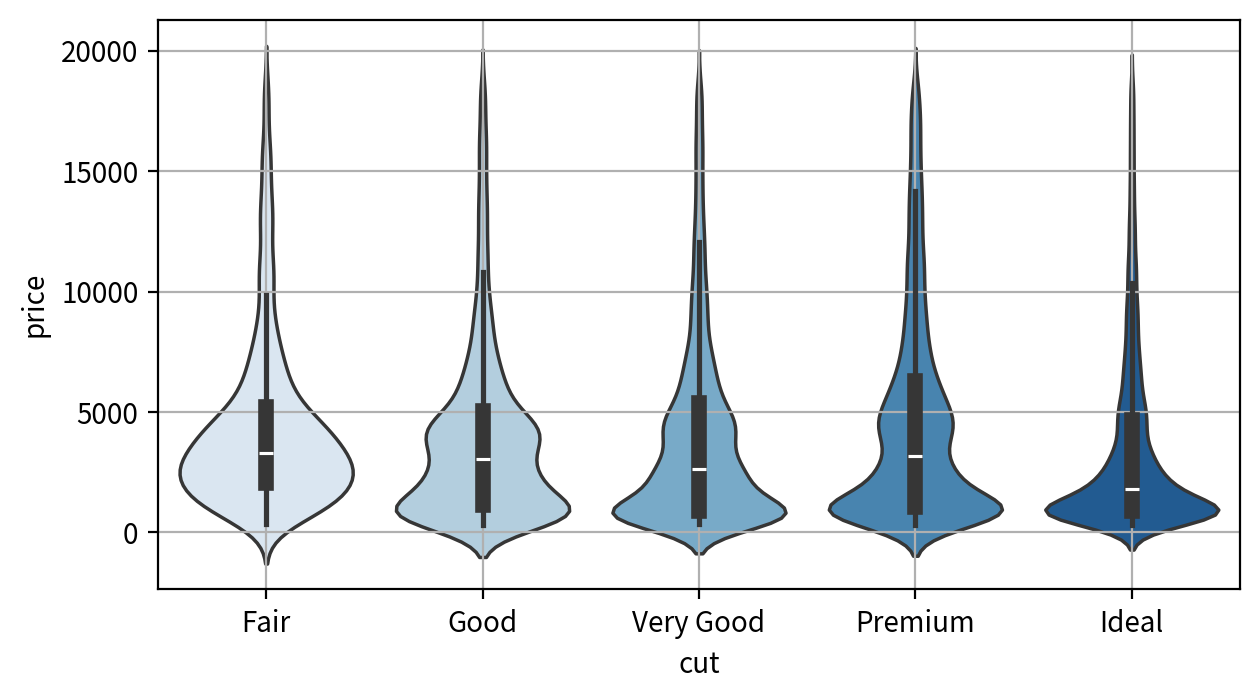

In [ ]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.violinplot(data=df,x='cut', y='price',palette='Blues')

ax.grid(True)
plt.tight_layout()
plt.show()
plt.close()

C:\Users\itwill\AppData\Local\Temp\ipykernel_16072\152510498.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=df,x='color', y='price',palette='Blues')


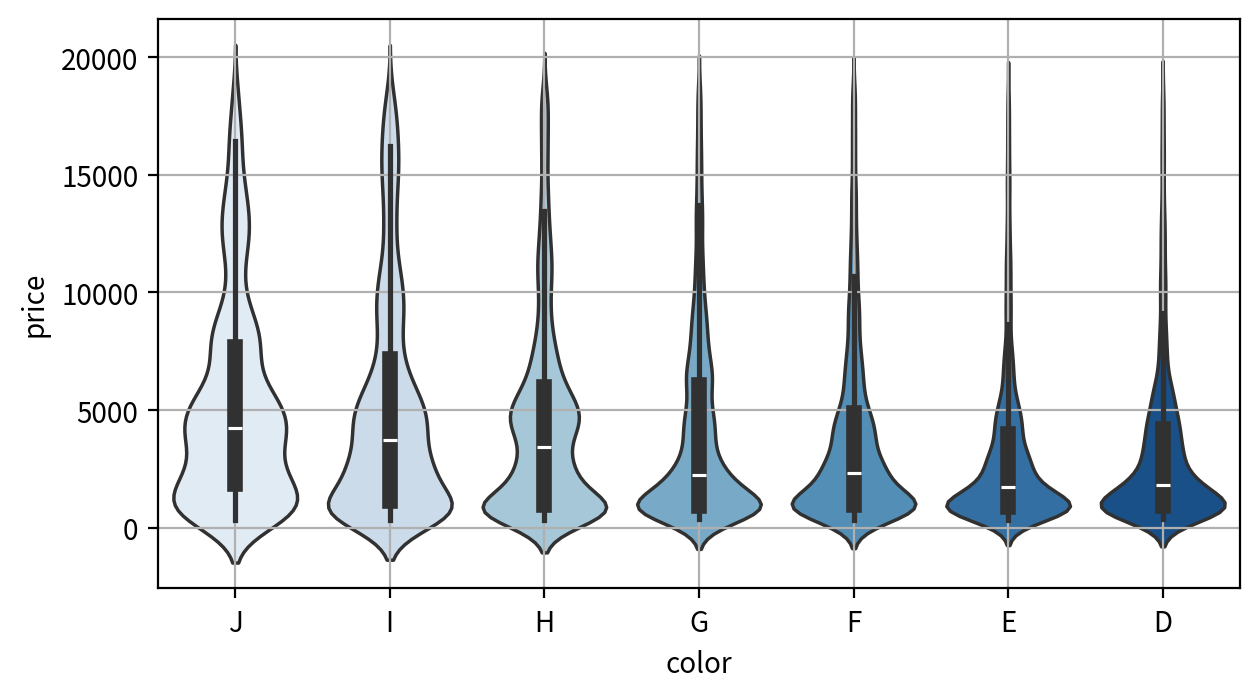

In [ ]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.violinplot(data=df,x='color', y='price',palette='Blues')

ax.grid(True)
plt.tight_layout()
plt.show()
plt.close()

C:\Users\itwill\AppData\Local\Temp\ipykernel_16072\1602312897.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=df,x='clarity', y='price',palette='Blues')


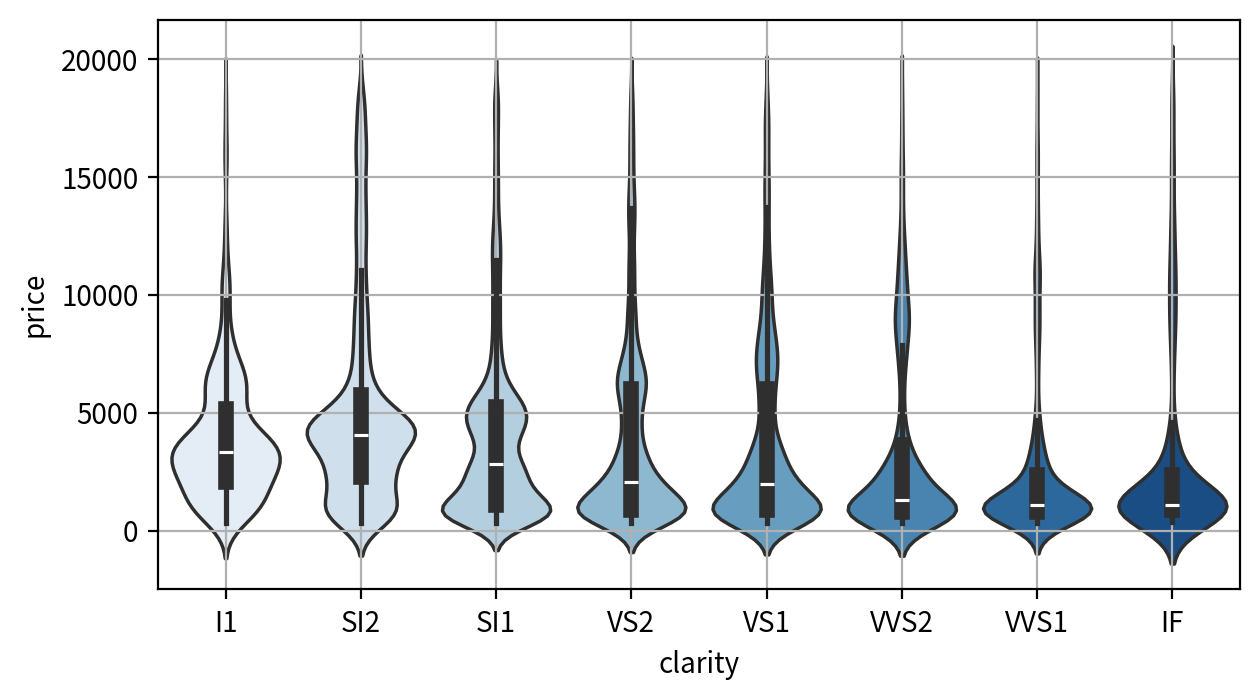

In [ ]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.violinplot(data=df,x='clarity', y='price',palette='Blues')

ax.grid(True)
plt.tight_layout()
plt.show()
plt.close()

# cut

등급이 오른쪽으로 갈수록 중앙값이 일관되게 상승하는 패턴은 관찰되지 않았다.
특히 ideal등급의 중앙값은 good이나 premium보다 낮게 나타난다.
또한 모든 cut등급에서 가격분포가 크게 겹쳐 있으며,
동일한 cut내에서도 가격 변동 폭이 매우 크다.
이는 cut 단독으로는 다이아몬드 가격을 명확히 구분하기 어렵다는 점을 의미한다.

# color

등급이 j에서d로 갈수록 중앙값이 전반적으로 감소하는 경향이 관찰되었다.
이는 color등급이 높을수록 가격이 높아질 것이라는 일반적인 기대와 다른 결과이다.
또한 모든 color등급에서 가격분포가 크게 겹쳐 있으며, 특히 G-F-E-D 구간은 가격 분포가 많이 중첩됨.
모든 color에서 고가 이상치가 존재

이는 color단독으로는 다이아몬드 가격을 설명하기에는 한계가 있다.
carat등 다른 변수의 영향이 함계 작용하고 있음을 시사한다.

# clarity

I1애서 IF로 갈수록 가격 중앙값이 일관되게 감소하는 경향이 관찰되었다.
즉, clarity 등급이 높아질수록 가격이 증가하는 패턴은 나타나지 않았다.

또한 인접한 clarity등급 간 가격분포가 크게 겹쳐 있으며, 모든 등급에서 고가 이상치가 존재한다.
이는  clarity 단독으로는 다이아몬드 가격을 명확히 설명하기 어렵다는 점을 시사한다.


특히 VS2·VS1 구간에서 상대적으로 높은 중앙값이 나타난 반면,
VVS 및 IF와 같은 높은 clarity 등급에서는 중앙값이 낮게 관찰된다.
이는 clarity 등급별로 포함된 carat 분포 차이가 가격 분포에 영향을 미친 결과로 해석할 수 있다.


 cut, color, clarity 모두 가격과 일정한 관련성을 보이지만, 세 변수 모두에서 가격 분포의 겹침이 크게 나타나 ㅇ단일 품질 변수만으로는 가격을 설명하기 어렵다.

# 미션5. "Premium 컷은 정말 더 비쌀까?"

귀무가설:premium컷 다이아몬드의 평균가격은 ideal컷보다 크지 않다.
대립가설:Premium 컷 다이아몬드의 평균 가격은 Ideal 컷보다 크다.
검정방법 선택이유:
두 집단(Premium, Ideal)의 평균 가격 차이를 비교하고자 하며,
두 집단은 서로 독립적이다.
표본 수가 충분히 크고(price 분포의 왜도를 고려해)
로그 변환된 가격(log(price))을 사용하면 정규성 가정을 완화할 수 있으므로,
독립표본 t-검정이 적절하다고 판단하였다.

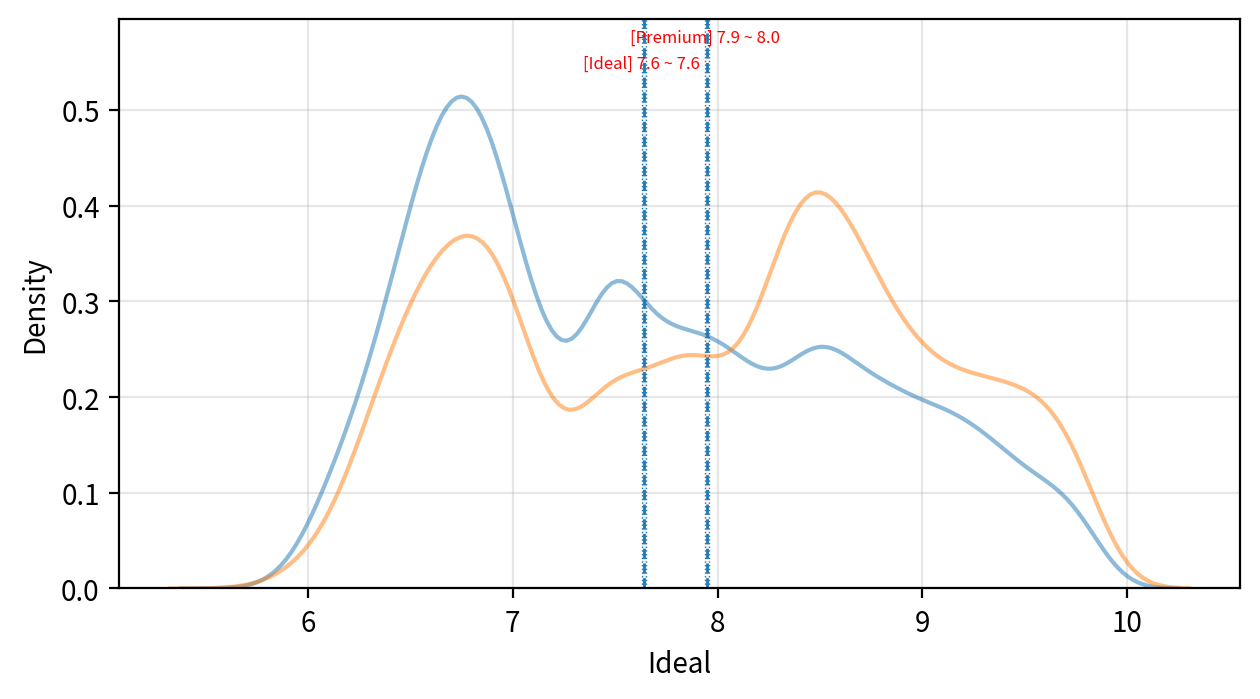

In [ ]:
# Premium, Ideal만 추출 + log_price 사용
data = df.loc[
    (df["cut"] == "Premium") | (df["cut"] == "Ideal"),
    ["cut", "log_price"]
].pivot(columns="cut", values="log_price")

 #확인할 데이터

width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)



for c in data.columns:
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    max = data[c].max()
    clevel = 0.95
    dof = len(data[c])-1
    sp_mean = data[c].mean()
    sp_std = data[c].std(ddof=1)
    sp_std_error = sp_std / sqrt(len(data[c]))
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin,cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    ax.text(x=(cmax-cmin)/2+cmin, y=ymax,
            s="[%s] %0.1f ~ %0.1f " % (c, cmin, cmax), horizontalalignment="center",
            verticalalignment="bottom",fontdict={"size":6, "color":"red"})

ax.grid(True, alpha=0.3)






plt.tight_layout()
plt.show()
plt.close()

표본 수가 충분히 크고,
가격 분포의 왜도를 완화하기 위해 로그 변환을 적용하였으므로
정규성 가정은 중심극한정리에 의해 완화된다고 판단하였다.
또한 두 집단의 분산이 동일하다고 가정하기 어려워
등분산 가정을 요구하지 않는 Welch의 독립표본 t-검정을 사용하였다.

In [ ]:
premium = df.loc[df["cut"] == "Premium", "log_price"]
ideal   = df.loc[df["cut"] == "Ideal", "log_price"]


t_stat, p_value = ttest_ind(
    premium,
    ideal,
    equal_var=False
)


p_value_one_sided = p_value / 2 if t_stat > 0 else 1

t_stat, p_value_one_sided

(np.float64(28.053299030307574), np.float64(3.787154793454233e-171))

In [ ]:
if p_value_one_sided < 0.05:
    print("유의수준 0.05에서 Premium 컷의 평균 가격이 Ideal 컷보다 높다.")
else:
    print("Premium 컷의 평균 가격이 Ideal 컷보다 높다고 보기 어렵다.")


유의수준 0.05에서 Premium 컷의 평균 가격이 Ideal 컷보다 높다.


로그 변환된 가격을 사용하여 Welch의 독립표본 t-검정을 수행한 결과,
유의수준 0.05에서 Premium 컷 다이아몬드의 평균 가격이 Ideal 컷보다 높다 
이는 같은 carat과 다른 품질 조건이 동일하다고 가정할 때, Premium 컷 다이아몬드가 Ideal 컷보다 시장에서는 더 높은 가격대로 거래되는 경향이 있음을 의미한다.

즉, 이 결과는 단순한 통계적 차이를 넘어, 컷 등급에 따라 소비자 또는 시장이 지불하는 가격 수준에 체계적인 차이가 존재함을 시사한다.

# 미션6."모든 컷은 서로 다를까?"

정규성검정
등분산성 검정
분산분석(끝나고 사후검정시행),회귀분석(상관분석먼저하고)



C:\Users\itwill\AppData\Local\Temp\ipykernel_16072\1936699269.py:42: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


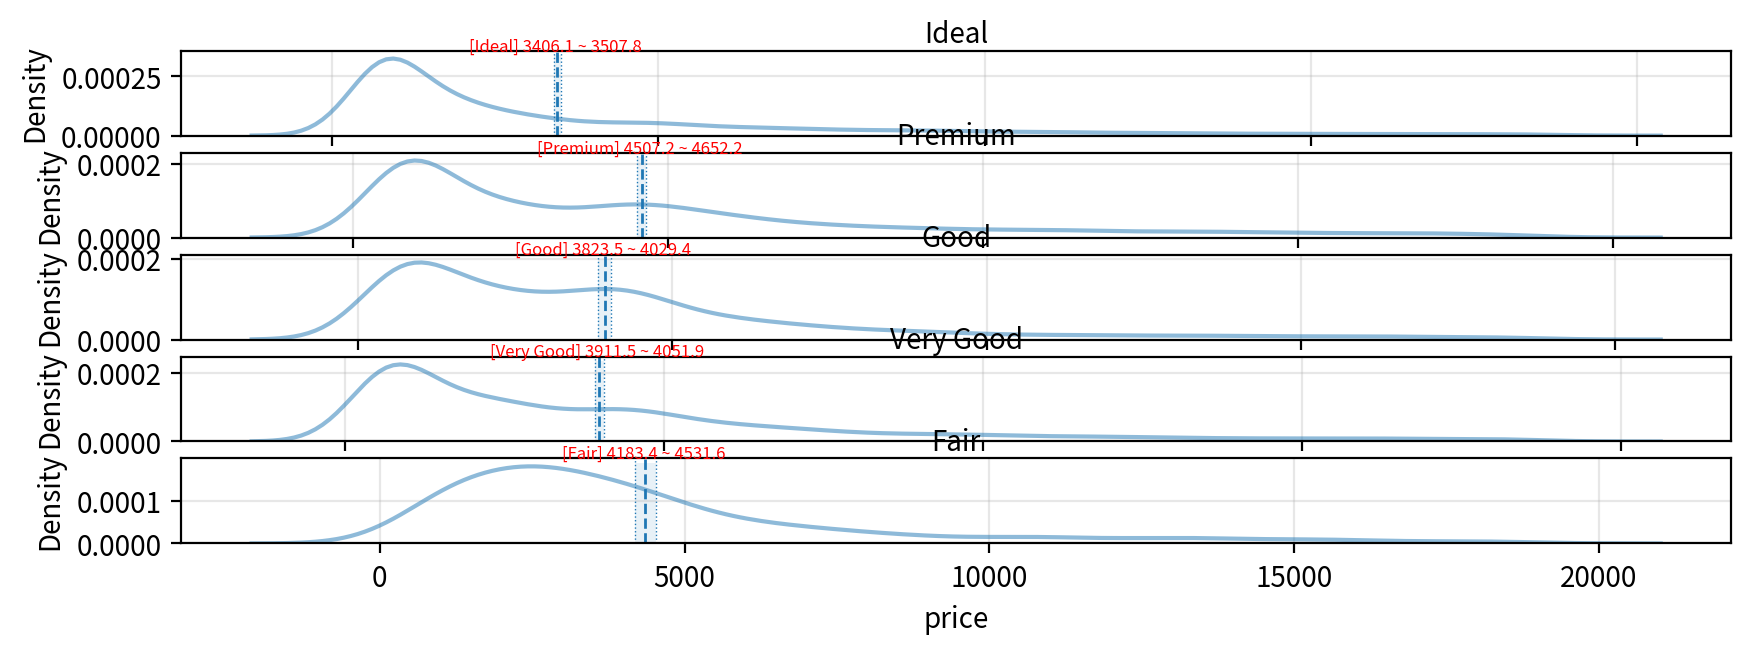

In [ ]:
field = 'price'

hue_field = 'cut'

hue_values = df[hue_field].unique()
hue_count = len(hue_values)

width_px = 2000
height_px = 640 
rows = hue_count
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

for i,v in enumerate(hue_values):
    temp = df[df[hue_field] == v]
    sb.kdeplot(data=temp, x=field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize=10, pad=3)


    max = temp[field].max()
    clevel = 0.95
    dof = len(temp[field]) - 1
    sp_mean = temp[field].mean()
    sp_std = temp[field].std(ddof=1)
    sp_std_error = sp_std / sqrt(len(temp[field]))
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
    ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

    ymin, ymax = ax[i].get_ylim()
    ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
    ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

    ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax,
            s="[%s] %0.1f ~ %0.1f " % (v, cmin, cmax), horizontalalignment="center",
            verticalalignment="bottom",fontdict={"size":6, "color":"red"})


plt.tight_layout()
plt.show()
plt.close()


1.모든 cut구간에서 kde는 오른쪽 꼬리가 긴형태를 보인다.
-대부분은 낮은 가격에 많이 분포하고 있음.
2.cut별 평균은 kde의 최고점보다  오른쪽에 있으며 fair 이 가장 높게 나타난다.
3.신뢰구간의 폭:ideal의 금액 변화가 제일 적고 fair의 금액변화는 제일크다.

In [ ]:
groups = [(name, grp['price'])for name, grp in df.groupby('cut')]


report = []
normal_dist = True

for name,series in groups:
    stat,p = normaltest(series)
    ok = p>0.05
    report.append({"field":name, "statistic":stat, "p-value":p,"result":ok})
    normal_dist = normal_dist and ok


if normal_dist:
    
        testname = "Bartlett"

        stat,p = bartlett(*[s.values for _, s in groups])

else:
    test_name = "Levene"

    stat,p = levene(*[s.values for  _, s in groups], center="median")
       
equal_var = p>0.05
report.append({"field": test_name, "statistic":stat, "p-value":p, "result":equal_var})

report_df =DataFrame(report).set_index('field')
report_df

C:\Users\itwill\AppData\Local\Temp\ipykernel_16072\2608912329.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [(name, grp['price'])for name, grp in df.groupby('cut')]


,statistic,p-value,result
field,,,
Fair,542.065306,1.958909e-118,False
Good,1568.698291,0.000000e+00,False
Very Good,3357.874309,0.000000e+00,False
Premium,2756.236244,0.000000e+00,False
Ideal,7268.307291,0.000000e+00,False
Levene,122.810356,1.582775e-104,False


In [ ]:
anova_df = origin[['price', 'cut']].copy()
anova_df

,price,cut
0,326,Ideal
1,326,Premium
2,327,Good
3,334,Premium
4,335,Good
...,...,...
53935,2757,Ideal
53936,2757,Good
53937,2757,Very Good
53938,2757,Premium


In [ ]:
if equal_var:
    pg_anova = anova(data=anova_df, dv='price', between='cut')

else:
    pg_anova = welch_anova(data=anova_df, dv='price', between='cut')

pg_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,cut,4,9398.605929,166.039774,1.381555e-137,0.012862


In [ ]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val <= 0.05 else "귀무")

'statistic: 166.040, p-value: 0.000, 대립가설 채택'

컷 품질()간 평균 금액의차이를 검정한 결과, 유의수준 0.05기준에서 통계적으로 유의한 차이가 확인되었다.
컷 품질이 금액 차이에 유의한 영향을 주는것으로 판단된다.

In [ ]:
if equal_var:
    print("=== Tukey HSD ===")
    hoc_df = pairwise_tukey(data=anova_df, dv='price', between='cut')
else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(anova_df, dv='price', between='cut')
    
hoc_df

=== Games-Howell ===


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Fair,Good,4358.757764,3928.864452,429.893312,103.132300,4.168367,2822.292938,3.050682e-04,0.117700
1,Fair,Ideal,4358.757764,3457.541970,901.215794,92.447366,9.748420,1894.787378,0.000000e+00,0.237674
2,Fair,Premium,4358.757764,4584.257704,-225.499940,96.151443,-2.345258,2210.585679,1.311690e-01,-0.052763
3,Fair,Very Good,4358.757764,3981.759891,376.997873,95.685251,3.939979,2168.043610,7.996461e-04,0.096819
4,Good,Ideal,3928.864452,3457.541970,471.322481,58.615397,8.040933,7484.674693,0.000000e+00,0.124513
5,Good,Premium,3928.864452,4584.257704,-655.393253,64.298906,-10.192915,10098.827780,3.855805e-12,-0.156623
6,Good,Very Good,3928.864452,3981.759891,-52.895439,63.599658,-0.831694,9668.624441,9.208512e-01,-0.013688
7,Ideal,Premium,3457.541970,4584.257704,-1126.715734,45.217181,-24.917868,26552.158305,0.000000e+00,-0.279710
8,Ideal,Very Good,3457.541970,3981.759891,-524.217921,44.217199,-11.855521,24333.685261,0.000000e+00,-0.135992
9,Premium,Very Good,4584.257704,3981.759891,602.497814,51.514514,11.695690,25843.822021,0.000000e+00,0.144782


cut에 따라 다이아몬드 가격은 전반적으로 유의미한 차이가 존재한다.
Premium cut은 Ideal, Good, Very Good cut보다 유의하게 높은 평균 가격을 보였다.
ideal컷이 전반적으로 가장 가격이 낮은그룹,premium 컷이 가장 가격이 높은 그룹
fari-premium,good-verygood에서 통계적으로 차이 없음.

# 미션7."품질 요인들은 서로 영향을 주고 받을까?"

In [ ]:
import pingouin as pg

# cut 기준 등분산성 검정
levene_cut = pg.homoscedasticity(
    data=df,
    dv='log_price',
    group='cut',
    method='levene'
)

# clarity 기준 등분산성 검정
levene_clarity = pg.homoscedasticity(
    data=df,
    dv='log_price',
    group='clarity',
    method='levene'
)

print(levene_cut)
print(levene_clarity)


                 W           pval  equal_var
levene  122.580235  2.492832e-104      False
                 W           pval  equal_var
levene  210.208412  2.382468e-309      False


In [ ]:
anova_result = pg.anova(
    data=df,
    dv='log_price',
    between=['cut', 'clarity'],
    detailed=True
)

print(anova_result)


          Source            SS       DF          MS           F  \
0            cut    465.599616      4.0  116.399904  120.842091   
1        clarity   2296.175982      7.0  328.025140  340.543614   
2  cut * clarity    299.359587     28.0   10.691414   11.099432   
3       Residual  51899.356822  53880.0    0.963240         NaN   

           p-unc       np2  
0  7.710683e-103  0.008891  
1   0.000000e+00  0.042368  
2   2.564097e-49  0.005735  
3            NaN       NaN  


In [ ]:
for _, row in anova_result.iterrows():
    source = row['Source']
    p_val = row['p-unc']

    if p_val <= 0.05:
        print(f"→ {source} 효과는 통계적으로 유의함 (p ≤ 0.05)")
    else:
        print(f"→ {source} 효과는 통계적으로 유의하지 않음 (p > 0.05)")


→ cut 효과는 통계적으로 유의함 (p ≤ 0.05)
→ clarity 효과는 통계적으로 유의함 (p ≤ 0.05)
→ cut * clarity 효과는 통계적으로 유의함 (p ≤ 0.05)
→ Residual 효과는 통계적으로 유의하지 않음 (p > 0.05)


Levene 검정 결과 등분산성 가정은 충족되지 않았다(p < .05).
이에 따라 가격 변수에 로그 변환을 적용하여 분산 안정화를 시도한 후
이원 분산분석을 수행하였다.
다만, 등분산성 위반이 완전히 해소되지 않았을 가능성이 있으므로
분석 결과 해석 시 주의가 필요하다.

In [ ]:
import pingouin as pg

posthoc_cut_clarity = {}

for c in origin['cut'].unique():
    sub = origin[origin['cut'] == c]

    res = pg.pairwise_ttests(
        data=df,
        dv='log_price',
        between='clarity',
        padjust='bonf'
    )

    posthoc_cut_clarity[c] = res[['A', 'B', 'p-corr', 'hedges']]


c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is depreca

In [ ]:


posthoc_cut_clarity['Ideal']


,A,B,p-corr,hedges
0,I1,SI2,5.191253e-05,-0.153519
1,I1,SI1,1.621579e-08,0.183797
2,I1,VS2,8.854646e-18,0.259862
3,I1,VS1,7.185673e-22,0.295533
4,I1,VVS2,2.737971e-51,0.499883
5,I1,VVS1,8.841839e-94,0.810581
6,I1,IF,9.671146e-64,0.713736
7,SI2,SI1,2.663727e-131,0.331926
8,SI2,VS2,9.430290e-195,0.409863
9,SI2,VS1,6.185203e-184,0.450757
